Are the contaminants being injected into the water column within the Salish Sea Atlantis Model within a timescale of 10 days as we might expect? 

How about uptake by the phytoplankton?

### Highres Tests
1. v6699_16 - updated code version (see SSAM-output-biopools.ipynb)
1. v6699_17 - updated code version + small number dummy contaminant file to zero out contaminants
1. reduced uptake rates of PAH for diatoms and picos to around 8.0e-03 mg/m^3 per day

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

### Package and file nports

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from PIL import Image
import glob
from IPython.display import Image as img
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [29]:
control_name = 'v6699_16_highres'
test_name = 'v6699_17_highres'
test2_name = 'v6699_17_highres3'
labels = [control_name,test_name,test2_name]
label = [test_name]

In [23]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [24]:
test_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_" + test_name + "/outputSalishSea.nc"
test2_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_" + test2_name + "/outputSalishSea.nc"
test = xr.open_dataset(str(test_path), decode_cf=True)
test2= xr.open_dataset(str(test2_path), decode_cf=True)

In [25]:
time = np.ma.filled(test.variables['t'], np.nan)

In [26]:
scenarios = [control, test, test2]
scen = [test]
cont = [control]

### Functions

In [9]:
def plot_pah(scenario, times, label):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        contam_tbl = np.ma.filled(scenario.variables[pah], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(times, contam_mass_t[0:times.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH')
    ax.set_title(label)

In [11]:
def plot_individual_pah(scenario, times, label, pah):
    fig, ax = plt.subplots(figsize = (14,3))
    contam_tbl = np.ma.filled(scenario.variables[pah], np.nan)
    volume_tbl = np.ma.filled(scenario.volume, np.nan)
    contam_mass_tbl = contam_tbl * volume_tbl
    contam_mass_tb = contam_mass_tbl.sum(axis=2)
    contam_mass_t = contam_mass_tb.sum(axis=1)

    ax.plot(times, contam_mass_t[0:times.size])
    ax.legend(pah)
    ax.set_ylabel('mg PAH')
    ax.set_title(label)

In [30]:
def tissue_mass(group, pah, scens, names=labels, time=time):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            oil_tbl = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan) # mgPAH / m3
            volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan) #m3
            oil_mass_tbl = oil_tbl * volume_tbl
            oil_mass_tb = oil_mass_tbl.sum(axis=2) 
            oil_mass_t = oil_mass_tb.sum(axis=1) 
            ax.plot(time, oil_mass_t[0:time.size],linewidth = 2, alpha=0.5) #semilogy
        
        #plt.ylabel('mg '+str(pah)+' / mg N ', fontsize=12)
        plt.ylabel('mg '+str(pah)+' inside '+str(species), fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);
    #print(sp_volume_tbl[1,60,:])
    #print(sp_volume_tbl[1,60,:]+(sp_volume_tbl[3,60,:]==0))

In [31]:
def individual_tissue_mass(species, pah, scens, names=labels, time=time):

    fig, ax = plt.subplots(figsize = (14,3))
    for scenario in scens:
        oil_tbl = np.ma.filled(scenario.variables[species + '_' + pah][:,:,0:6], np.nan) # mgPAH / m3
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan) #m3
        oil_mass_tbl = oil_tbl * volume_tbl
        oil_mass_tb = oil_mass_tbl.sum(axis=2) 
        oil_mass_t = oil_mass_tb.sum(axis=1) 
        ax.plot(time, oil_mass_t[0:time.size],linewidth = 2, alpha=0.5) #semilogy
    
    plt.ylabel('mg '+str(pah)+' inside '+str(species), fontsize=12)
    ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [34]:
def individual_tissue_mass_log(species, pah, scens, names=labels, time=time):

    fig, ax = plt.subplots(figsize = (14,3))
    for scenario in scens:
        oil_tbl = np.ma.filled(scenario.variables[species + '_' + pah][:,:,0:6], np.nan) # mgPAH / m3
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan) #m3
        oil_mass_tbl = oil_tbl * volume_tbl
        oil_mass_tb = oil_mass_tbl.sum(axis=2) 
        oil_mass_t = oil_mass_tb.sum(axis=1) 
        ax.semilogy(time, oil_mass_t[0:time.size],linewidth = 2, alpha=0.5)
    
    plt.ylabel('mg '+str(pah)+' inside '+str(species), fontsize=12)
    ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [24]:
def tissue_mass_log(group, pah, scens, names=labels, time=time):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            oil_tbl = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan)
            volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan)
            oil_per_N_tbl = oil_tbl * (1/(volume_tbl+(volume_tbl==0)))
            oil_per_N_tb = oil_per_N_tbl.sum(axis=2) 
            oil_per_N_t = oil_per_N_tb.sum(axis=1) 
            ax.semilogy(time, oil_per_N_t[0:time.size],linewidth = 2, alpha=0.5)
        
        plt.ylabel('mg '+str(pah)+' / mg N ', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [27]:
def plot_biomass(group, scens, names=labels):
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2)
            pelagic_oiled = pelagic_oiled.sum(axis=1)
            ax.plot(time, pelagic_oiled[0:time.size], linewidth = 2)
        
        plt.ylabel('mg N m$^{-3}$', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [28]:
def map_tissue_mass(group, pah, scenarios, v_max=None, v_min=None, _cmap=cm.Purples):
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(group), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for species in group:
        for scenario in scenarios:
            dVar_s = scenario.variables[group[species] + '_' + pah][:,:,0:6]
            volume = scenario.variables['volume'][:,:,0:6]
            #dVar_s = dVar_s.sum(axis=2)
            dVar_mass = dVar_s * volume
            vpah_tb = dVar_mass.sum(axis=2)
            vpah_b = vpah_tb.sum(axis=0)

            # Add scenario data to Atlantis spatial data
            map_df['pah'] = vpah_b
            map_df.loc[land_boxes, 'pah'] = 0

            ax = fig.add_subplot(gs[0, position])
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=-0.5) 
            ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
                legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
                )
            tit = str(species + '_' + pah)
            ax.set_title(tit)
            map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
            land_df.plot(ax=ax, color='white');
        position=position+1

In [29]:
def map_aggregate_time(variable_name, scens, names=labels, v_max=None, v_min=None):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        dVar_s = scenario.variables[variable_name]
        dVar_s = dVar_s.mean(axis=2)
        pah = dVar_s.mean(axis=0)

        # Add scenario data to Atlantis spatial data
        map_df['pah'] = pah
        map_df.loc[land_boxes, 'pah'] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title(names[scenario.index], fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1

In [30]:
def map_time_mass(variable_name, scens, time, names=labels, v_max=None, v_min=None):
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        var_bl = scenario.variables[variable_name][time,:,0:6]
        vol_bl = scenario.variables['volume'][time,:,0:6]
        var_mass_bl = var_bl * vol_bl
        var_mass_b = var_mass_bl.mean(axis=1)

        # Add scenario data to Atlantis spatial data
        map_df[variable_name] = var_mass_b
        map_df.loc[land_boxes, variable_name] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = variable_name, cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title(variable_name, fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1
    fig.suptitle(names)

In [31]:
def map_time_depth(variable_name, scens, time, depth, names=labels, v_max=None, v_min=None):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    depth_range = ['700 m','400 m', '250 m', '100 m', '50 m', 'surface 25 m', 'sediment']
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        dVar_s = scenario.variables[variable_name][time,:,depth]
        #dVar_s = dVar_s.mean(axis=1)
        #pah_s = dVar_s.mean(axis=1)
        pah_s = dVar_s

        # Add scenario data to Atlantis spatial data
        map_df['pah'] = pah_s
        map_df.loc[land_boxes, 'pah'] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title((variable_name + ' - ' + depth_range[depth] + '_' + str(time)), fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1
        map_df['pah'] = 0

### Water Column

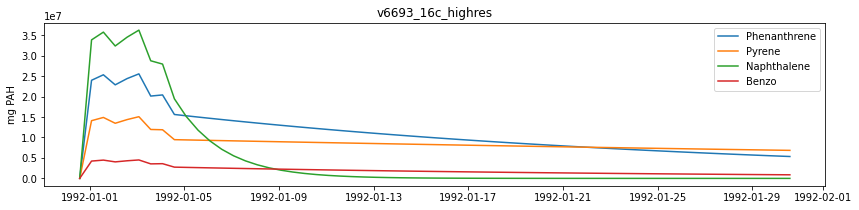

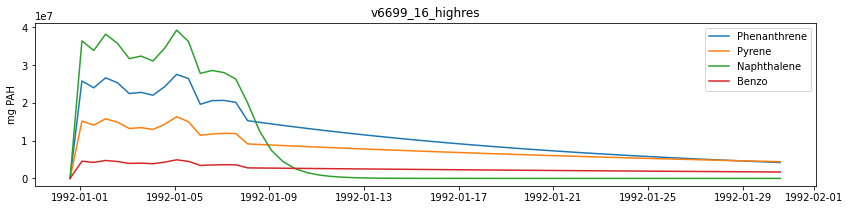

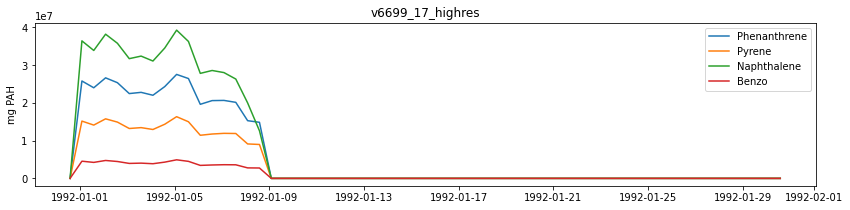

In [10]:
for scenario, label in zip(scenarios, labels):
    plot_pah(scenario, time, label)

When observing results of the high resolution output, every 0.5 days, the contaminants are injected into the model as expected over the 8-day injection period defined in the contaminants.nc input file. v6699_16 has a 0 dummy file at the end, which was intended to zero out the contaminants after injection (which it does not do), while v6699_17 has a dummy file with a small number rather than zero, and this works much better at removing the contaminants from the water column.

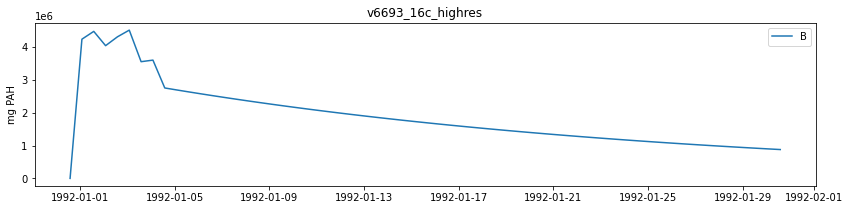

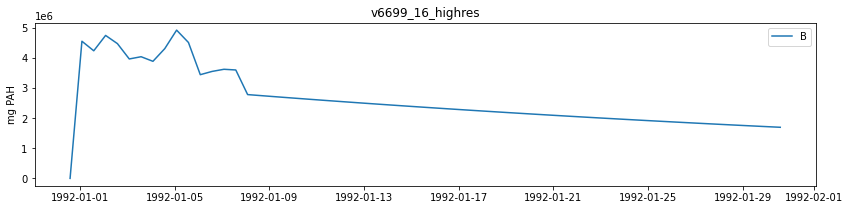

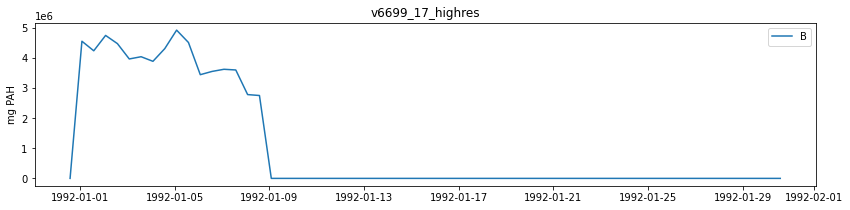

In [12]:
for scenario, label in zip(scenarios, labels):
    plot_individual_pah(scenario, time, label, 'Benzo')

A closer look at Benzo, which is not as easy to see in the original plot above.

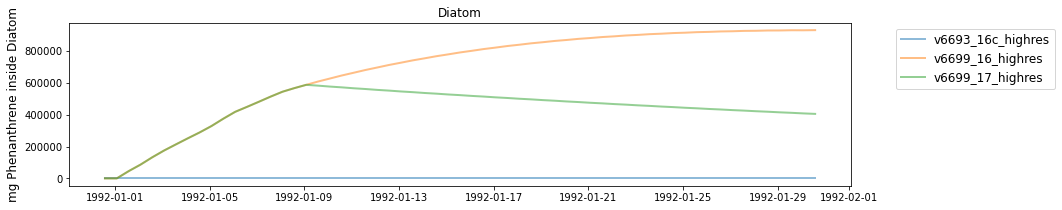

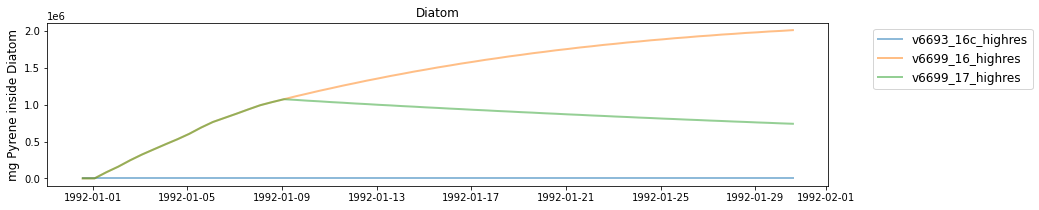

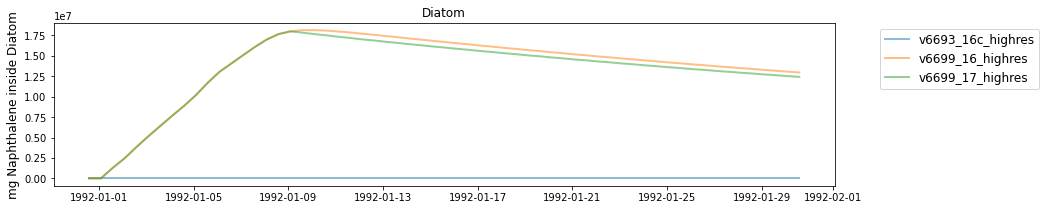

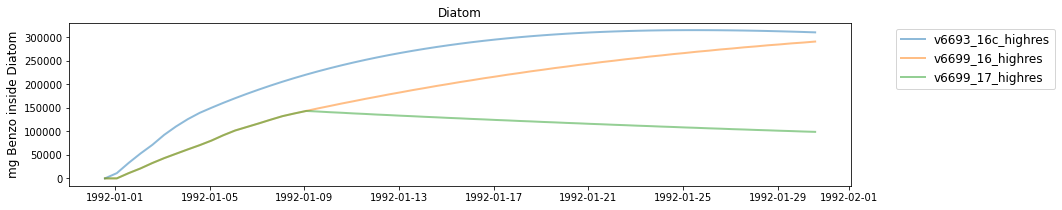

In [19]:
for pah in groups.pahs:
    individual_tissue_mass('Diatom', pah, scenarios)

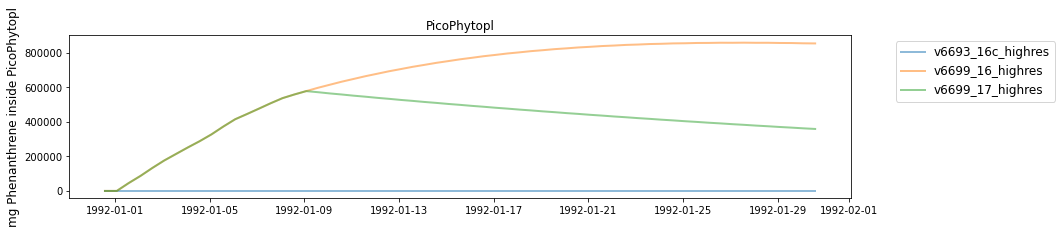

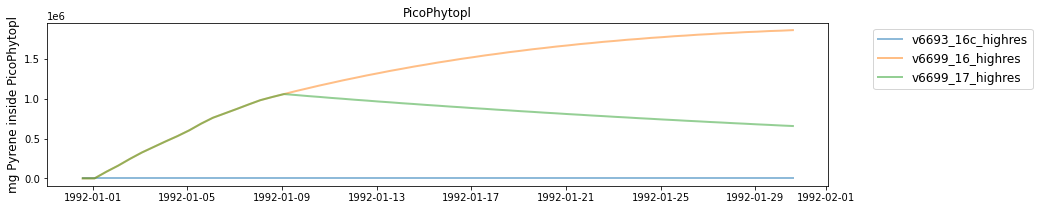

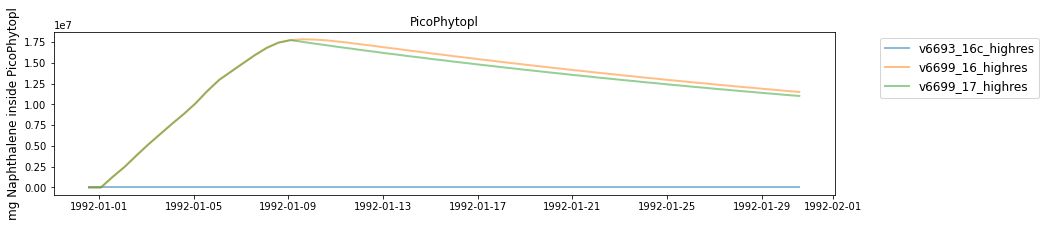

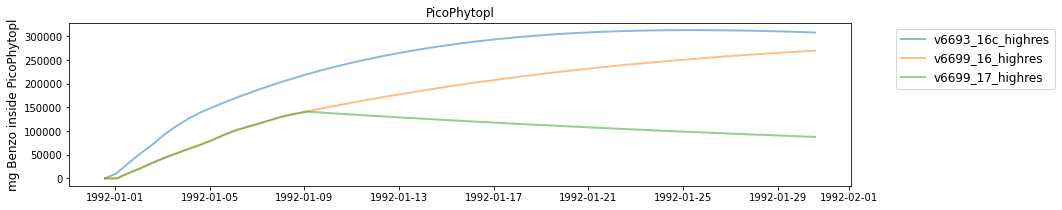

In [21]:
for pah in groups.pahs:
    individual_tissue_mass('PicoPhytopl', pah, scenarios)

Decreasing the uptake rates for Naphthalene, Phenanthrene and Pyrene

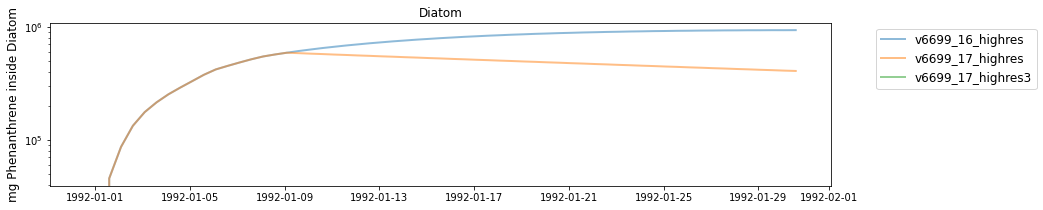

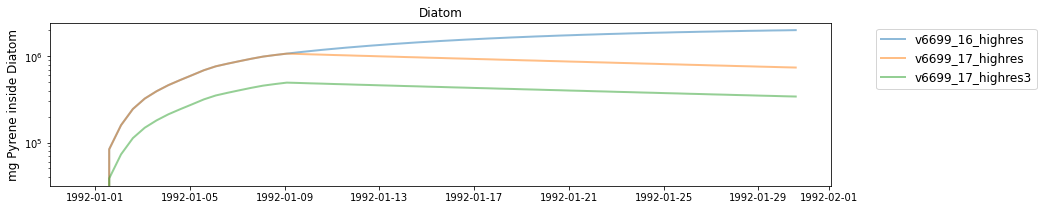

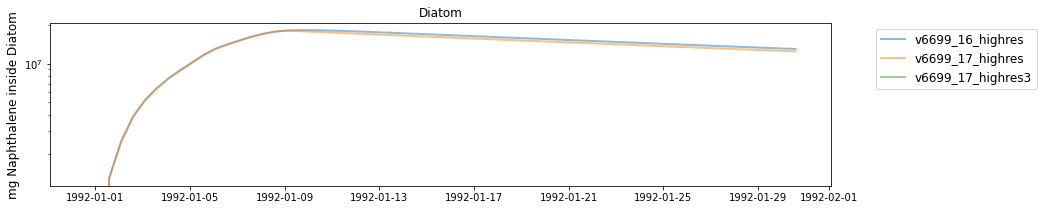

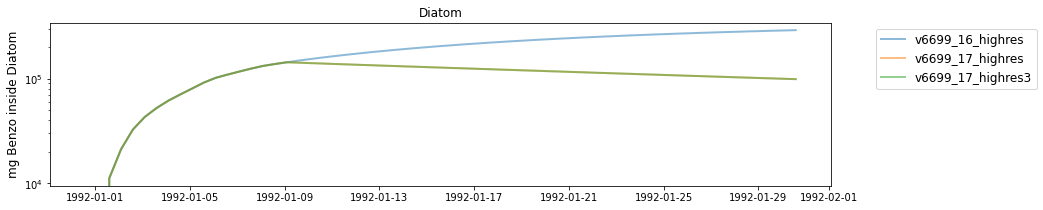

In [35]:
for pah in groups.pahs:
    individual_tissue_mass_log('Diatom', pah, scenarios)

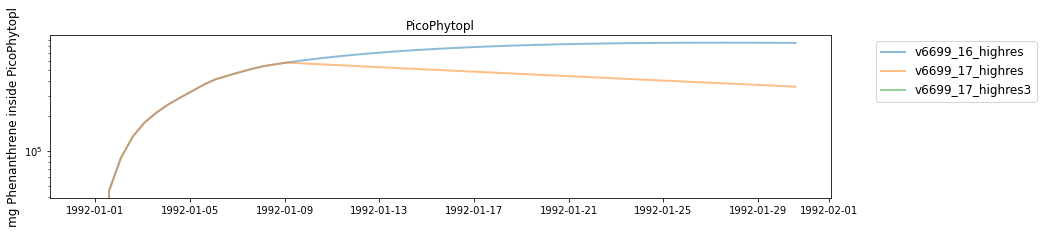

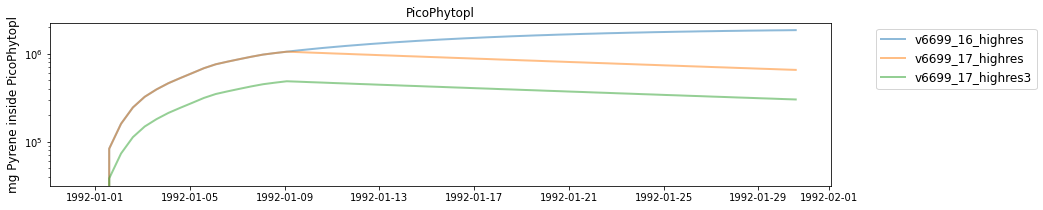

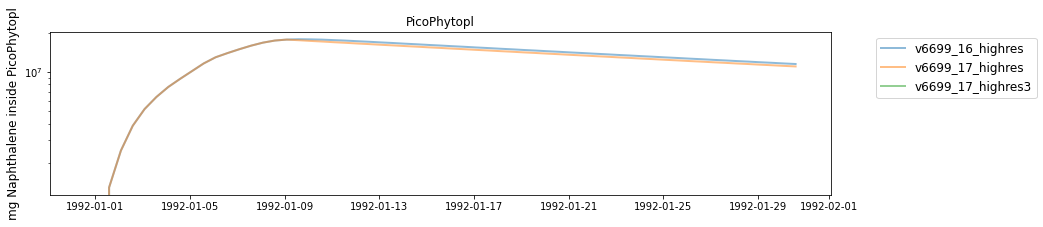

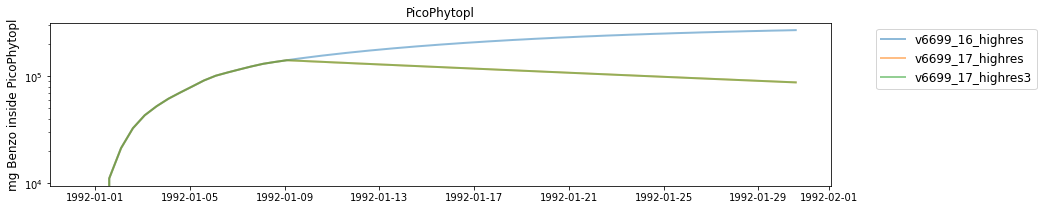

In [36]:
for pah in groups.pahs:
    individual_tissue_mass_log('PicoPhytopl', pah, scenarios)

A reduction of the uptake rate to 8.0e-03 mg/m^3 per day was tolderated for Pyrene, but not for Naph or Phenanthrene.